This is an expiremental notebook where you can specify a dataframe path and see how fastText performs on the dataset.

The dataset will remove issues made by detected bots, and additional bots can be added as well. 

Each label is predicted as a fastText binary classification task. Negative samples are evenly distributed amongst other labels.

The output will be a dataframe with the precision, accuracy, and recall for each label, computed using k-fold cross validation.

In [244]:
import pandas as pd
import numpy as np
from skift import FirstColFtClassifier
import itertools
import collections
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [313]:
# one of USER or REPO must be empty

# username of person or organization
USER = ''
# OR  person-org-name/repo-name
REPO = 'pandas-dev/pandas'

In [314]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

savename = USER if USER else ('-_-').join(REPO.split('/'))

issues_df = pd.read_csv(os.path.join('../data', savename + '.csv')).drop_duplicates()

In [315]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
1292,pandas-dev/pandas/1539,pandas-dev/pandas,Release 0.10.0,To keep the milestone open\n,2012-06-27 14:43:19,wesm,0,NaN
2502,pandas-dev/pandas/3243,pandas-dev/pandas,Dataframe ctor dies when passed a list contain...,``` python\npd.DataFrame([DataFrame([])])\n\n/...,2013-04-02 19:04:41,ghost,1,Bug
1418,pandas-dev/pandas/1683,pandas-dev/pandas,Tz-aware DatetimeIndex shift issue,"```\ndr = pandas.date_range('2011/1/1', '2012/...",2012-07-26 15:17:33,wesm,2,Bug\tTimeseries
3087,pandas-dev/pandas/4223,pandas-dev/pandas,BLD: sparc test_decimalDecodeTest - {u'a': 4.5...,```\n=========================================...,2013-07-12 14:17:33,yarikoptic,0,NaN
17195,pandas-dev/pandas/19209,pandas-dev/pandas,IntervalIndex nbytes computation,"Currently, it looks like `IntervalIndex.nbytes...",2018-01-12 15:01:18,TomAugspurger,1,Interval


In [316]:
# output most popular labels

cutoff = 50

label_lst = list(itertools.chain.from_iterable([ls.split('\t') for ls in issues_df.labels.dropna()]))
counter = collections.Counter(label_lst)

for a,b in counter.most_common():
    if b > cutoff:
        print(f'{a} {b}')

Bug 5801
Enhancement 2590
Docs 1679
Indexing 1378
Usage Question 1341
Timeseries 1292
good first issue 1255
API Design 1249
Reshaping 1096
Dtypes 1059
Groupby 1055
Duplicate 949
Testing 806
IO CSV 723
Performance 713
MultiIndex 696
Visualization 670
Missing-data 642
Error Reporting 624
Regression 622
Numeric Operations 588
IO Data 528
Categorical 507
Compat 493
Timezones 489
Needs Tests 486
CI 442
Needs Discussion 430
Needs Triage 423
Output-Formatting 406
Needs Info 406
ExtensionArray 389
Build 372
IO Excel 360
Timedelta 318
IO HDF5 306
Deprecate 289
IO JSON 267
Clean 261
Frequency 255
IO SQL 253
Resample 250
Internals 225
Algos 207
Strings 202
Period 198
IO HTML 196
Window 193
Apply 193
Sparse 181
API - Consistency 165
Closing Candidate 149
Dependencies 143
NA - MaskedArrays 141
Interval 139
Code Style 127
Index 127
Constructors 126
Unicode 115
Refactor 111
Windows 109
IO Parquet 109
Typing 104
Blocker 84
Styler 78
Ideas 75
IO Google 70
Unreliable Test 70
Reduction Operations 64
IO S

In [317]:
# define synonyms, first in set will be used name

synsets = [['kind/bug', 'bug'],
          ]

In [318]:
# equate synonyms

for syn in synsets:
    equate_syns = lambda x: syn[0] if x in syn[1:] else x
    issues_df.labels = issues_df.labels.apply(lambda x: '\t'.join(list(set([equate_syns(l) for l in x.split('\t')]))) if type(x)==str else x)

(0, 6)

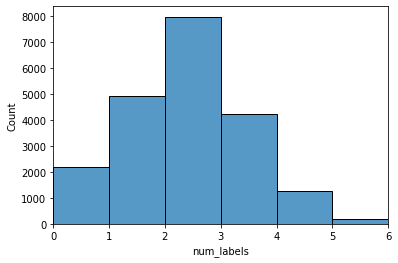

In [319]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins = int(max(issues_df.num_labels)))
ax.set_xlim((0,6))

In [320]:
# view most common issue creators

issues_df.created_by.value_counts(ascending = False).head(10)

jreback               1277
wesm                  1028
TomAugspurger          710
jorisvandenbossche     626
jbrockmendel           459
ghost                  300
toobaz                 210
datapythonista         191
WillAyd                185
cpcloud                171
Name: created_by, dtype: int64

In [321]:
# first find bots transparently tagged as such

is_bot = lambda x: x[-5:] == '[bot]'

all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print('bots found:')
for b in bots:
    print('\t', b)

bots found:


In [322]:
# choose any additional bot accounts whose issues to not count

additional_bots = ['sesheta']

In [323]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]

In [324]:
# most popular labels, nearly finalized

cutoff = 50
final_labels = []

label_lst = list(itertools.chain.from_iterable([ls.split('\t') for ls in issues_df.labels.dropna()]))
counter = collections.Counter(label_lst)

for a,b in counter.most_common():
    if b > cutoff:
        print(f'{a} {b}')
        final_labels.append(a)

Bug 5801
Enhancement 2590
Docs 1679
Indexing 1378
Usage Question 1341
Timeseries 1292
good first issue 1255
API Design 1249
Reshaping 1096
Dtypes 1059
Groupby 1055
Duplicate 949
Testing 806
IO CSV 723
Performance 713
MultiIndex 696
Visualization 670
Missing-data 642
Error Reporting 624
Regression 622
Numeric Operations 588
IO Data 528
Categorical 507
Compat 493
Timezones 489
Needs Tests 486
CI 442
Needs Discussion 430
Needs Triage 423
Output-Formatting 406
Needs Info 406
ExtensionArray 389
Build 372
IO Excel 360
Timedelta 318
IO HDF5 306
Deprecate 289
IO JSON 267
Clean 261
Frequency 255
IO SQL 253
Resample 250
Internals 225
Algos 207
Strings 202
Period 198
IO HTML 196
Window 193
Apply 193
Sparse 181
API - Consistency 165
Closing Candidate 149
Dependencies 143
NA - MaskedArrays 141
Interval 139
Code Style 127
Index 127
Constructors 126
Unicode 115
Refactor 111
Windows 109
IO Parquet 109
Typing 104
Blocker 84
Styler 78
Ideas 75
IO Google 70
Unreliable Test 70
Reduction Operations 64
IO S

In [325]:
# choose labels whose issues you don't want to include in the dset

exclude = []

In [326]:
# remove those labels

for l in exclude:
    if l in final_labels:
        final_labels.remove(l)
    
issues_df = issues_df[issues_df.labels.apply(lambda x: not any([l in x.split('\t') for l in exclude]) if type(x) == str else True)]

In [327]:
# choose issues you do not wish to attempt to predict

# dont_pred = ['priority/P2', 'lifecycle/frozen', 'lifecycle/stale', 'priority/P3', 'priority/P1', 'lifecycle/rotten']

dont_pred = []

for dp in dont_pred:
    final_labels.remove(dp)

(0, 6)

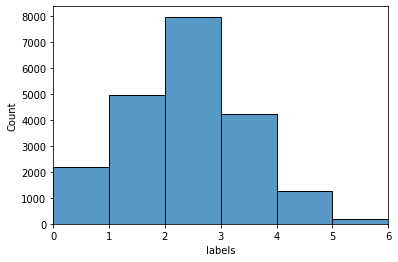

In [328]:
# output histogram of number of relevant labels, finalized

set_dp = set(dont_pred)

num_rel_issues = issues_df.labels.apply(lambda x: len(set(x.split('\t')).difference(set_dp)) if type(x) == str else 0)

ax = sns.histplot(num_rel_issues, bins = int(max(num_rel_issues)))
ax.set_xlim((0,6))

In [329]:
# preprocessing
issues_df = issues_df.fillna({'title': '', 'body': ''})
issues_df['body'] = issues_df['body'].apply(lambda x: x.replace('\n', ' <N> ').replace('\r', ' <R> '))
issues_df['input'] = issues_df['title'] + ' <SEP> ' + issues_df['body']

In [330]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    labelled = issues_df[~issues_df.labels.isna()]
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labelled[labelled.labels.apply(lambda x: label in x.split('\t'))]
    n = len(pos_samples)
    remaining = labelled[labelled.id.apply(lambda x: not label in x.split('\t'))]
    n_neg = 0
    per_label = n//len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining[remaining.labels.apply(lambda x: lbl in x.split('\t'))]
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            if i != len(final_labels_) - 1:
                per_label = (n - n_neg)//(len(final_labels_) - i - 1)
        remaining = remaining[remaining.labels.apply(lambda x: not lbl in x.split('\t'))]
        neg_ids = neg_ids.union(set(neg_samples.id))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_samples) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_samples) - len(neg_ids):
            neg_ids = neg_ids.union(set(unlabelled.sample(len(pos_samples) - len(neg_ids)).id))
        else:
            neg_ids = neg_ids.union(set(unlabelled.ids))
            pos_samples = pos_samples.sample(len(neg_ids))
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)].input
    X = np.concatenate((final_neg_samples.values, pos_samples.input.values)).reshape(-1, 1)
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(pos_samples))))
    return X, y.astype(int)

In [331]:
def predict_label(label, k = 5):
    """
    validates fastText model on the given label, using k-fold cross validation
    """
    X, y = get_subdataset(label)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    accuracy = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(X):
        model = FirstColFtClassifier()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accuracy.append(np.mean(preds == y_test))
        precision_ = preds[preds == 1] == y_test[preds == 1]
        if len(precision_) != 0:
            precision.append(np.mean(precision_))
        recall_ = preds[y_test == 1] == y_test[y_test == 1]
        if len(recall_) != 0:
            recall.append(np.mean(recall_))
    return pd.DataFrame([[label, len(X), np.mean(accuracy), np.mean(precision), np.mean(recall)]], columns = ['label' ,'n', 'accuracy', 'precision', 'recall'])

In [ ]:
predicted_labels = []
for label in tqdm(final_labels):
    predicted_labels.append(predict_label(label))

  0%|          | 0/74 [00:00<?, ?it/s]

NOTE: for now, labels with a low amount of samples are very biased towards predicting a 0, or a negative prediction. This could be fixed by adjusting hyperparameters (once they are explored) and/or finetuning on a pretrained model.

In [333]:
# save and print the validation results

results_df = pd.concat(predicted_labels).sort_values('n', ascending = False)

results_df

,label,n,accuracy,precision,recall
0,Bug,11602,0.652560,0.639148,0.716736
0,Enhancement,5180,0.650386,0.732724,0.495424
0,Docs,3358,0.703691,0.707328,0.708635
0,Indexing,2756,0.637145,0.610468,0.778155
0,Usage Question,2682,0.597685,0.638949,0.452202
0,Timeseries,2584,0.587464,0.637522,0.417364
0,good first issue,2510,0.600797,0.578376,0.764967
0,API Design,2498,0.637302,0.626693,0.676013
0,Reshaping,2192,0.587121,0.593763,0.625068
0,Dtypes,2118,0.608605,0.614458,0.618858


In [334]:
# set conditions for saving the model of a potential label

min_accuracy = 0.55

min_precision = 0.6

min_recall = 0.0

# add in the labels you want to have a model for anyway

addins = ['kind/bug', 'kind/feature']

to_save = results_df[((results_df.accuracy > min_accuracy) & (results_df.precision > min_precision) & (results_df.recall > min_recall)) | results_df.label.isin(addins)]

labels_to_save = to_save.label.values

to_save

,label,n,accuracy,precision,recall
0,Bug,11602,0.652560,0.639148,0.716736
0,Enhancement,5180,0.650386,0.732724,0.495424
0,Docs,3358,0.703691,0.707328,0.708635
0,Indexing,2756,0.637145,0.610468,0.778155
0,Usage Question,2682,0.597685,0.638949,0.452202
0,Timeseries,2584,0.587464,0.637522,0.417364
0,API Design,2498,0.637302,0.626693,0.676013
0,Dtypes,2118,0.608605,0.614458,0.618858
0,Testing,1612,0.570157,0.610525,0.709209
0,IO Data,1056,0.614603,0.662256,0.469917


In [335]:
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')

for label in labels_to_save: 
    X, y = get_subdataset(label)
    model = FirstColFtClassifier()
    model.fit(X, y)
    model.model.save_model(os.path.join('saved_models', label.replace('/', '_') + '.bin'))

In [310]:
# save information of who to ignore (so the app knows not to tag these issues)

with open('botlist.txt', 'w') as f:
    for b in bots:
        f.write(b)
        f.write('\n')
        
# save label names

with open('labellist.txt', 'w') as f:
    for b in labels_to_save:
        f.write(b)
        f.write('\n')